In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from gensim.models import Word2Vec, word2vec
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import logging
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import numpy as np
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
logging.basicConfig(level=logging.INFO)
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Repo/amazon.csv')

In [ ]:
df

,Text,Score
0,The description and photo on this product need...,3
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5
...,...,...
49995,Stays on continuously without shutting off! It...,4
49996,these look great in our 10 gallon tank- colors...,4
49997,"This works great, but needs a better way to at...",4
49998,she absolutely LOVES this thing. I dice up gre...,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7af7ca3c90>]],
      dtype=object)

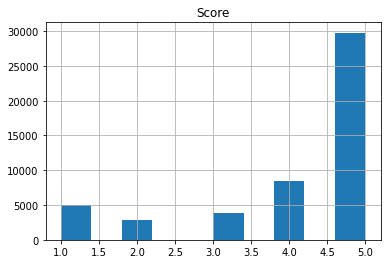

In [ ]:
df.hist('Score')

In [ ]:
from nltk.tokenize import punkt
# Load the 'PUNKT' tokenizer used for splitting reviews into sentences
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Labelling good and bad reviews

To obtain binary class labels, reviews with 4-5 stars are considered good and assigned a '1' class label while reviews with less than 3 stars are considered bad and assigned a '0' class label. Reviews with 3 stars are ignored.

In [ ]:
reviews = df.loc[df['Score']!= 3]

In [ ]:
reviews

,Text,Score
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5
5,"My eight year old loves this game, whenever he...",5
...,...,...
49995,Stays on continuously without shutting off! It...,4
49996,these look great in our 10 gallon tank- colors...,4
49997,"This works great, but needs a better way to at...",4
49998,she absolutely LOVES this thing. I dice up gre...,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7af934dd90>]],
      dtype=object)

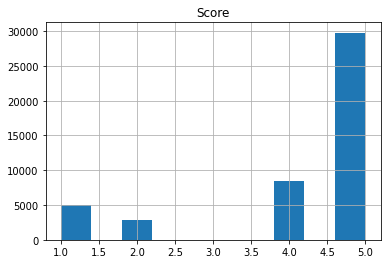

In [ ]:
reviews.hist('Score')

In [ ]:
reviews['Class'] = 1 * (reviews['Score'] > 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews

,Text,Score,Class,UserId
1,This was a great book!!!! It is well thought t...,5,1,19703
2,"I am a first year teacher, teaching 5th grade....",5,1,43979
3,I got the book at my bookfair at school lookin...,5,1,21559
4,Hi! I'm Martine Redman and I created this puzz...,5,1,14428
5,"My eight year old loves this game, whenever he...",5,1,45232
...,...,...,...,...
49995,Stays on continuously without shutting off! It...,4,1,48343
49996,these look great in our 10 gallon tank- colors...,4,1,31901
49997,"This works great, but needs a better way to at...",4,1,30356
49998,she absolutely LOVES this thing. I dice up gre...,5,1,44691


'UserId' and 'ProductId' columns insertion

In [ ]:
reviews['UserId'] = np.random.randint(10000,57000, size=len(reviews))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews['ProductId'] = np.random.randint(45000,95000, size=len(reviews))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews

,Text,Score,Class,UserId,ProductId
1,This was a great book!!!! It is well thought t...,5,1,19703,60022
2,"I am a first year teacher, teaching 5th grade....",5,1,43979,76623
3,I got the book at my bookfair at school lookin...,5,1,21559,76325
4,Hi! I'm Martine Redman and I created this puzz...,5,1,14428,84076
5,"My eight year old loves this game, whenever he...",5,1,45232,70836
...,...,...,...,...,...
49995,Stays on continuously without shutting off! It...,4,1,48343,57532
49996,these look great in our 10 gallon tank- colors...,4,1,31901,57373
49997,"This works great, but needs a better way to at...",4,1,30356,47394
49998,she absolutely LOVES this thing. I dice up gre...,5,1,44691,67418


train/test Split

Split the data set into training and test sets. To ensure indendence of training and test set and generalizability of the model, make sure that no product (identified by ProductId) and no user (identified by UserId) is present in both training and test set.

In [ ]:
reviews.sort_values('ProductId', axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
train_size = int(len(reviews) * 0.8)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

In [ ]:
test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [ ]:
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

Training set contains 36878 reviews.
Test set contains 4240 reviews (4980 removed).


In [ ]:
n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 82.77% positive reviews
Test set contains 82.24% positive reviews


df['Text'] -> Preprocessing 

Convert each review in the training set to a list of sentences where each sentence is in turn a list of words. Besides splitting reviews into sentences, non-letters and (optionally) stop words are removed and all words coverted to lower case.

In [ ]:
# συνάρτηση για τη μετατροπή κριτικής σε λίστα λέξεων
def review_to_wordlist(review, remove_stopwords=True):
  # remove non-letter content
  review_Text = re.sub("[^a-zA-Z]"," ", review)
  
  # convert to lower case and split at whitespace
  words = review_Text.lower().split()

  # remove stop words (true/false)
  if remove_stopwords:
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
      
  return words

In [ ]:
# συνάρτηση για τη μετατροπή κριτικής σε λίστα προτάσεων
def review_to_sentences(review, remove_stopwords=False):
  # use the NLTK tokenizer to split the paragraph into sentences
  raw_sentences = tokenizer.tokenize(review.strip())

  # each sentence is furthermore split into words
  sentences = []

  for raw_sentence in raw_sentences:
    # If a sentence is empty, skip it
    if len(raw_sentence) > 0:
      sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
  
  return sentences

In [ ]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
  train_sentences += review_to_sentences(review, tokenizer)

In [ ]:
train_sentences

[['cats', 'loved'],
 ['always',
  'swatting',
  'faucet',
  'dripping',
  'water',
  'shower',
  'bother',
  'one',
  'bit'],
 ['like', 'play', 'stream', 'catch', 'water', 'lick', 'paws'],
 ['cute', 'see'],
 ['durable', 'wont', 'tip'],
 ['works', 'great'],
 ['son', 'months', 'loves'],
 ['personally', 'going', 'deaf'],
 ['one',
  'volume',
  'setting',
  'feel',
  'like',
  'stuck',
  'sitting',
  'next',
  'massive',
  'speaker',
  'rock',
  'concert'],
 ['gift', 'opened', 'minutes', 'ago', 'ready', 'hide'],
 ['decibels', 'brutal'],
 ['melatonin', 'perfect', 'thing', 'help', 'get', 'sleep'],
 ['make', 'groggy', 'morning', 'strong'],
 ['something', 'use', 'every', 'night'],
 ['helped', 'get', 'sleep', 'schedule', 'back', 'track'],
 ['still', 'fall', 'asleep', 'nights', 'used'],
 ['bought', 'panel', 'pen', 'bichon', 'puppies'],
 ['enough',
  'room',
  'bed',
  'water',
  'bowl',
  'positive',
  'plenty',
  'big',
  'enough',
  'fully',
  'grown'],
 ['well', 'made', 'durable'],
 ['bought'

Training the word2vec model

In [ ]:
model_name = 'train_model'
# Set values for various word2vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

In [ ]:
if not os.path.exists(model_name): 
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 76392 words, keeping 10551 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 153062 words, keeping 14864 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 227984 words, keeping 18104 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 303195 words, keeping 20863 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 379095 words, keeping 23155 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 453876 words, keeping 25226 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 528947 words, keeping 27175 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 605309 words, keeping 29

The vector representations for words allow us to explore what the model learned. Using the distance between embedded words, we can find that are similar or dissimilar to one another.

Testing the word2vec model reliablility 

In [ ]:
model.doesnt_match("banana apple orange sausage".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'orange'

In [ ]:
model.doesnt_match("vanilla chocolate cinnamon dish".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'dish'

In [ ]:
model.most_similar("great")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('awesome', 0.7096397280693054),
 ('good', 0.6892490983009338),
 ('fantastic', 0.6561834812164307),
 ('terrific', 0.6497364044189453),
 ('wonderful', 0.638217568397522),
 ('perfect', 0.6258244514465332),
 ('excellent', 0.6122324466705322),
 ('wonders', 0.5329975485801697),
 ('wonderfully', 0.5301828384399414),
 ('amazing', 0.5269237160682678)]

In [ ]:
model.most_similar("awful")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('horrible', 0.8385311365127563),
 ('strange', 0.8381247520446777),
 ('nasty', 0.8173820376396179),
 ('unpleasant', 0.8144256472587585),
 ('terrible', 0.7976224422454834),
 ('gross', 0.7901630997657776),
 ('amazing', 0.7654399871826172),
 ('faint', 0.7651761174201965),
 ('weird', 0.7626680135726929),
 ('aftertaste', 0.7431635856628418)]

In [ ]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('narrow', 0.7067701816558838),
 ('hazard', 0.6974265575408936),
 ('raised', 0.6945888996124268),
 ('ideal', 0.6733931303024292),
 ('rail', 0.6723325848579407),
 ('padded', 0.666151762008667),
 ('comfortably', 0.6602327823638916),
 ('serves', 0.658972978591919),
 ('protects', 0.6583083868026733),
 ('smallest', 0.6582205891609192)]

In [ ]:
model.similar_by_vector(model['beer'] - model['alcohol'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('present', 0.6670196056365967),
 ('dolls', 0.6659000515937805),
 ('stocking', 0.6221233606338501),
 ('nephew', 0.6178584098815918),
 ('birthday', 0.6067573428153992),
 ('barbie', 0.6058813333511353),
 ('movie', 0.6033848524093628),
 ('christmas', 0.6018719673156738),
 ('sons', 0.5966938734054565),
 ('picked', 0.5951670408248901)]

Build classifier using word embedding

In [127]:
def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
      if word in index2word_set: 
        nwords = nwords + 1.
        feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [128]:
def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
      review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
      counter = counter + 1.
    
    return review_feature_vecs

Calculate average feature vectors for training and test sets

In [ ]:
clean_train_reviews = []
for review in train_reviews['Text']:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
    trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)

In [ ]:
clean_test_reviews = []
for review in test_reviews['Text']:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

Fit a random forest to the training data, using 100 trees

In [ ]:
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, train_reviews['Class'])

Remove instances in test set that could not be represented as feature vectors

In [ ]:
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    test_reviews.drop(test_reviews.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(test_reviews)

In [ ]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

In [ ]:
print(classification_report(test_reviews['Class'], result))

Compute ROC curve and area under the curve

In [ ]:
probs = forest.predict_proba(testDataVecs)[:, 1]

fpr, tpr, _ = roc_curve(test_reviews['Class'], probs)
auc = roc_auc_score(test_reviews['Class'], probs)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()